In [1]:
import os
import sys
sys.path.append("/home/pervinco/BKAI-NeoPolyp")

import cv2
import yaml
import copy
import torch
import random
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from data.BKAIDataset import BKAIDataset
from utils import load_img_mask, decode_mask, decode_image, visualize
from data.batch_preprocess import encode_mask


In [2]:
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

## Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = min([os.cpu_count(), config["batch_size"] if config["batch_size"] > 1 else 0, 8])

In [3]:
data_dir = config["data_dir"]
image_dir = f"{data_dir}/train"
mask_dir = f"{data_dir}/train_mask"
text_path = f"{data_dir}/train.txt"

with open(text_path, "r") as f:
    files = [x.strip() for x in f.readlines()]

print(len(files))

800


711 a0b47aa6b7b1fecb5579bf4a5ced589c


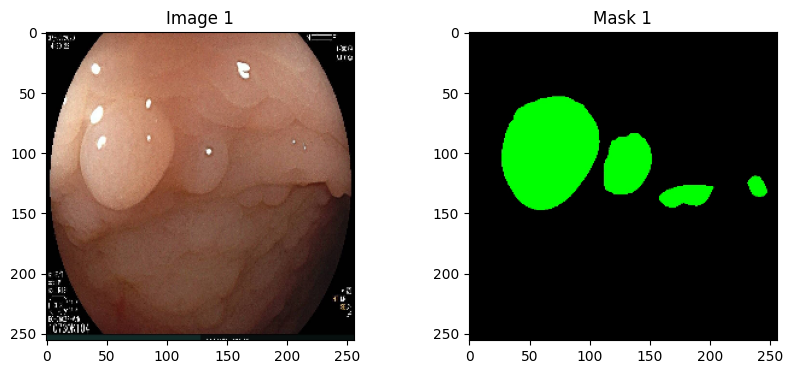

In [4]:
index = random.randint(0, len(files)-1)
index = 711
file = files[index]
print(index, file)

image_path, mask_path = f"{image_dir}/{file}.jpeg", f"{mask_dir}/{file}.jpeg"
image, mask = load_img_mask(image_path, mask_path)

visualize([image], [mask])

In [5]:
import numpy as np
from scipy.ndimage import label

def crop_colors_from_mask_and_image(image, mask, margin=1):
    red_mask = ((mask[:, :, 0] >= 200) & (mask[:, :, 0] <= 255)).astype(int)
    green_mask = ((mask[:, :, 1] >= 200) & (mask[:, :, 1] <= 255)).astype(int)
    
    labeled_red, num_red = label(red_mask)
    labeled_green, num_green = label(green_mask)
    
    red_crops, green_crops = [], []
    
    # Crop for each connected red component
    for i in range(1, num_red + 1):
        y, x = np.where(labeled_red == i)
        y_min, y_max, x_min, x_max = y.min(), y.max(), x.min(), x.max()
        
        cropped_img = image[y_min-margin:y_max+margin, x_min-margin:x_max+margin].copy()
        cropped_mask = mask[y_min-margin:y_max+margin, x_min-margin:x_max+margin].copy()
        
        red_crops.append((cropped_img, cropped_mask))
    
    # Crop for each connected green component
    for i in range(1, num_green + 1):
        y, x = np.where(labeled_green == i)
        y_min, y_max, x_min, x_max = y.min(), y.max(), x.min(), x.max()
        
        cropped_img = image[y_min-margin:y_max+margin, x_min-margin:x_max+margin].copy()
        cropped_mask = mask[y_min-margin:y_max+margin, x_min-margin:x_max+margin].copy()
        
        green_crops.append((cropped_img, cropped_mask))
    
    return red_crops, green_crops


In [6]:
red_crops, green_crops = crop_colors_from_mask_and_image(image, mask, margin=1)
print(len(red_crops), len(green_crops))

0 4


In [15]:
def mixup(crops, base_image, base_mask, threshold=200):
    piece_transform = A.Compose([A.Rotate(limit=90, border_mode=0, p=0.6),
                                 A.HorizontalFlip(p=0.7),
                                 A.VerticalFlip(p=0.7)])
    
    base_transform = A.Compose([A.Rotate(limit=90, border_mode=0, p=0.6),
                                A.HorizontalFlip(p=0.7),
                                A.VerticalFlip(p=0.7)])   

    B_height, B_width, _ = base_image.shape
    mixup_track_mask = np.zeros((B_height, B_width))
    
    for crop in crops:
        crop_image, crop_mask = crop[0], crop[1]

        piece_transformed = piece_transform(image=crop_image, mask=crop_mask)
        t_piece_image, t_piece_mask = piece_transformed["image"], piece_transformed["mask"]

        # random_height, random_width = random.randint(30, crop_mask.shape[0]), random.randint(30, crop_mask.shape[1])
        # t_piece_image = cv2.resize(t_piece_image, (random_height, random_width))
        # t_piece_mask = cv2.resize(t_piece_mask, (random_height, random_width))

        mixed = False
        height, width, _ = t_piece_image.shape
        for i in range(0, B_height - height):
            for j in range(0, B_width - width):
                region_mask = base_mask[i:i+height, j:j+width]
                region_track = mixup_track_mask[i:i+height, j:j+width]
                
                if (region_mask[:, :, :3].sum(axis=2) <= threshold).all() and not region_track.any():
                    alpha_mask = 0.5
                    base_mask[i:i+height, j:j+width] = region_mask * alpha_mask + t_piece_mask * (1 - alpha_mask)
                    region_image = base_image[i:i+height, j:j+width]
                    alpha_image = 0.5
                    base_image[i:i+height, j:j+width] = region_image * alpha_image + t_piece_image * (1 - alpha_image)
                    
                    mixup_track_mask[i:i+height, j:j+width] = 1
                    
                    mixed = True
                    break

            if mixed:
                break
        

    base_transformed = base_transform(image=base_image, mask=base_mask)
    t_base_image, t_base_mask = base_transformed["image"], base_transformed["mask"]
        
    return t_base_image, t_base_mask


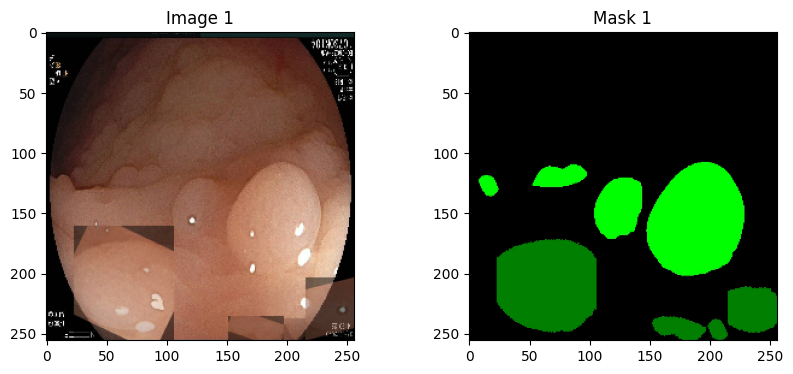

In [16]:
total_crops = red_crops + green_crops
mixed_base_image, mixed_base_mask = mixup(total_crops, copy.deepcopy(image), copy.deepcopy(mask))
visualize([mixed_base_image], [mixed_base_mask])

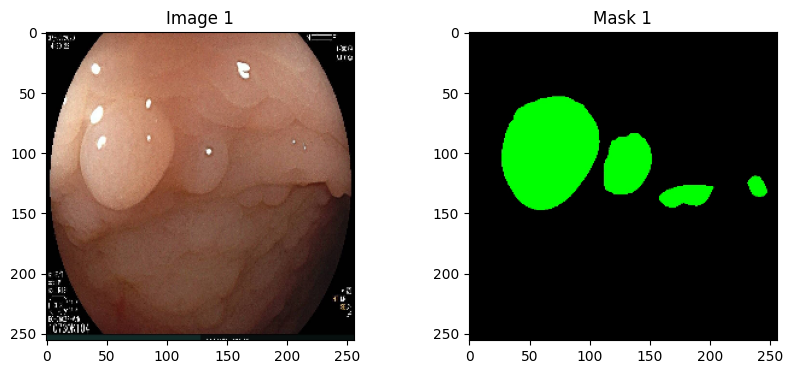

In [17]:
visualize([image], [mask])

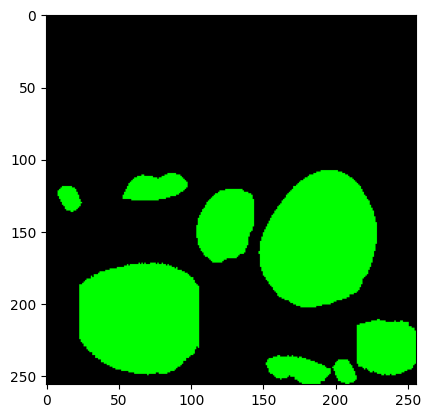

In [18]:
encoded_mask = encode_mask(mixed_base_mask)
decoded_mask = decode_mask(encoded_mask)

plt.imshow(decoded_mask)